In [39]:
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tensorflow as tf

## Step 1. Import the data from the given .csv file (Google_Stock_Price_Train.csv  Download Google_Stock_Price_Train.csv).

In [34]:
df=pd.read_csv("/content/Google_Stock_Price_Train.csv")
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (1258, 6)


,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


## Step 2. Preprocess the data as you see fit

## Step 3. Split into 80% train 20% prediction

In [35]:
#80% of 1258 is 1006
training_set = df.iloc[:1006, 1:2].values
test_set = df.iloc[1006:, 1:2].values

In [36]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1006):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
#Shape = (946, 60, 1) (values, time-step,label)

(946, 60, 1)


## Step 4. Train the model on the data

In [37]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 150, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.5))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.5))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.4))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.3))
# Adding the output layer
model.add(Dense(units = 1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 60, 150)           91200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 60, 100)           100400    
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 60, 100)           80400     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)               

In [41]:
# Compiling the RNN
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'mean_squared_error')

es=EarlyStopping(monitor='val_loss',patience=14, mode='min', restore_best_weights=True )
# Fitting the RNN to the Training set
model.fit(X_train, y_train, validation_split=0.2, epochs = 200, batch_size = 32, callbacks=[es])

Epoch 1/200
24/24 [==============================] - 9s 151ms/step - loss: 0.0052 - val_loss: 0.0105
Epoch 2/200
24/24 [==============================] - 2s 77ms/step - loss: 0.0037 - val_loss: 0.0059
Epoch 3/200
24/24 [==============================] - 2s 76ms/step - loss: 0.0037 - val_loss: 0.0077
Epoch 4/200
24/24 [==============================] - 2s 77ms/step - loss: 0.0036 - val_loss: 0.0106
Epoch 5/200
24/24 [==============================] - 2s 77ms/step - loss: 0.0032 - val_loss: 0.0090
Epoch 6/200
24/24 [==============================] - 2s 78ms/step - loss: 0.0026 - val_loss: 0.0092
Epoch 7/200
24/24 [==============================] - 2s 76ms/step - loss: 0.0031 - val_loss: 0.0058
Epoch 8/200
24/24 [==============================] - 2s 77ms/step - loss: 0.0031 - val_loss: 0.0076
Epoch 9/200
24/24 [==============================] - 2s 77ms/step - loss: 0.0031 - val_loss: 0.0096
Epoch 10/200
24/24 [==============================] - 2s 77ms/step - loss: 0.0027 - val_loss: 0.004

In [43]:
# Getting the predicted stock price of 2015
# 20% of data is 252
dataset_train = df.iloc[:1006, 1:2]
dataset_test = df.iloc[1006:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
Y_test = []
for i in range(60, 312):
    X_test.append(inputs[i-60:i, 0])
    Y_test.append(inputs[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# Shape of test data same format, but smaller sample (192, 60, 1)

(252, 60, 1)


In [44]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [45]:
predicted_stock_price.shape

(252, 1)

## Step 5. Report on the results of your model

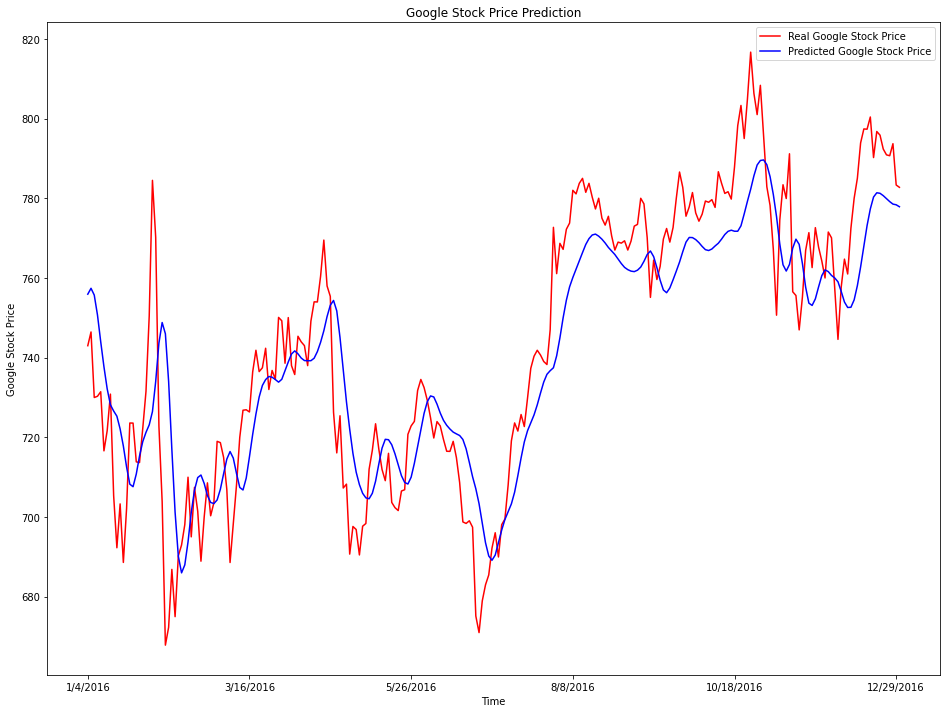

In [48]:
# Visualising the results
plt.figure(figsize=(16,12))
plt.plot(df.loc[1006:, 'Date'],dataset_test.values, color = 'red', label = 'Real Google Stock Price')
plt.plot(df.loc[1006:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.xticks(np.arange(0,252,50))
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

Comments:

The code had to be modified a bit from the demo as the google stock price data had only 1258 rows instead of 1259 rows. In order to incorporate the change, the number of test batches generated decreased from 459 to 458. In the graph we can see that the predicted data is close to the original data. The LSTM model has followed the trend however it was not able to make accurate predictions on the data after 10th october. 